<a href="https://colab.research.google.com/github/yn2a75/benkyokai/blob/main/Kikagaku_Bert%E6%96%87%E6%9B%B8%E5%88%86%E9%A1%9E%E6%BC%94%E7%BF%92_%E3%83%8D%E3%82%AC%E3%83%86%E3%82%A3%E3%83%96%E5%88%A4%E5%AE%9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 必要なライブラリのインストール

In [2]:
! pip install -q transformers==4.4.0
! pip install -q pytorch_lightning
! pip install -q torchmetrics

     |████████████████████████████████| 2.1 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 55.1 MB/s 
     |████████████████████████████████| 3.3 MB 39.3 MB/s 
     |████████████████████████████████| 527 kB 4.3 MB/s 
     |████████████████████████████████| 397 kB 78.7 MB/s 
     |████████████████████████████████| 134 kB 81.7 MB/s 
     |████████████████████████████████| 952 kB 86.3 MB/s 
     |████████████████████████████████| 596 kB 62.4 MB/s 
     |████████████████████████████████| 829 kB 82.2 MB/s 
     |████████████████████████████████| 1.1 MB 51.3 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 271 kB 84.8 MB/s 
     |████████████████████████████████| 144 kB 91.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
import pytorch_lightning as pl
import transformers

import torchmetrics
from torchmetrics.functional import accuracy



In [4]:
#RUNTIME が出たため、指示通りに環境変数の設定をする
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [5]:
#gpuかどうかを確認する記載を追加
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
import torchtext
print(torch.__version__)
print(torchtext.__version__)
print(pl.__version__)

1.10.0+cu111
0.11.0
1.5.10


In [7]:
torch.cuda.get_device_name(0)

'Tesla T4'

# データセットの準備

In [8]:
import pandas as pd

In [9]:
#GoogleDriveをマウント
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [49]:
train_df=pd.read_csv("/content/drive/MyDrive/kikagakuNLP/prac_data2/train.csv", header=None, names=['contents', 'label_id'])
val_df=pd.read_csv("/content/drive/MyDrive/kikagakuNLP/prac_data2/val.csv" ,header=None, names=['contents', 'label_id'])
test_df=pd.read_csv("/content/drive/MyDrive/kikagakuNLP/prac_data2/test.csv" , header=None, names=['contents', 'label_id'])

In [50]:
train_df

,contents,label_id
0,利益面では、売上原価率が上昇するとともに、販売費を主に販売費及び一般管理費が増加いたしました...,0
1,台湾ではパッケージ基板向け薬品売上が好調に推移いたしました,1
2,電子部品向け金属粉の販売状況につきましては、スマートフォン関連需要に加え、軟磁性材向けの販売...,1
3,当連結会計年度における世界経済は、米国市場では、新政権の誕生により一時混乱が見られたものの、...,1
4,この結果、商業施設事業の売上高は23億36百万円(前期比0.5％増)、減価償却費減少などによ...,1
...,...,...
1372,経費面においては、引き続き光熱費などの削減に努めましたが、売上増加に伴う人員の増強や10月か...,0
1373,こうした中、わが国経済は、堅調な設備投資や欧米・アジア向け輸出の増加等により、回復基調が継続...,1
1374,またインターホン設備等の更新需要も増加いたしました,1
1375,営業損益につきましては、営業利益4億45百万円となり、前期に比べ3億15百万円、243.2%...,1


In [51]:
# csvファイルとして保存する
train_df.to_csv('train.csv', header=None, index=None)
val_df.to_csv('val.csv', header=None, index=None)
test_df.to_csv('test.csv', header=None, index=None)

In [52]:
#後に ID → カテゴリ、カテゴリ → ID の変換を行うことを前提として、カテゴリの辞書を作成しておく。
id2cat = {0:"negative",1:"positive"}
cat2id = {"negative":0,"positive":1} 

# Tokenizerを用いたデータの準備
Tokenizerの用意

In [14]:
#必要なライブラリをインストール
!pip install -q fugashi
!pip install -q ipadic

     |████████████████████████████████| 568 kB 4.1 MB/s 
     |████████████████████████████████| 13.4 MB 4.2 MB/s 


In [15]:
from transformers import BertJapaneseTokenizer
#分かち書き用のtokenizer

tokenizer= BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

In [16]:
# 分かち書き用の tokenizer
text = list(train_df['contents'])[0]

# return_tensors に pt(PyTorch) を選択
wakati_ids = tokenizer.encode(text, return_tensors='pt')

print('各単語に振られている id：', wakati_ids)
print('id のサイズ：', wakati_ids.size())

各単語に振られている id： tensor([[    2,  5161,   635,    12,     9,     6,  6446,   385, 29120,   786,
            14,  4312,    34,   869,     6,  1011,  2251,    11,   137,     7,
          1011,  2251,   920,   654,  1251,  2251,    14,  2157,  6785, 28454,
          3913,    10,    45,   225,     6,  1790,  5161,     6,   226, 28917,
          5161,   920, 12241,  9177,     7, 15310,    34,   162, 28692,  2947,
          5161,     9,  1346, 29662,    13,   297,  3913,    10,     3]])
id のサイズ： torch.Size([1, 59])


In [17]:
print('分かち書きした単語：',tokenizer.convert_ids_to_tokens(wakati_ids[0]))

分かち書きした単語： ['[CLS]', '利益', '面', 'で', 'は', '、', '売上', '原', '##価', '率', 'が', '上昇', 'する', 'とともに', '、', '販売', '費', 'を', '主', 'に', '販売', '費', '及び', '一般', '管理', '費', 'が', '増加', 'いた', '##し', 'まし', 'た', 'こと', 'により', '、', '営業', '利益', '、', '経', '##常', '利益', '及び', '親会社', '株主', 'に', '帰属', 'する', '当', '##期', '純', '利益', 'は', '減', '##益', 'と', 'なり', 'まし', 'た', '[SEP]']


#Bert用TokenizerとTorchTextを使用したデータセットの作成

In [18]:
#Bert用の分かち書きをする関数を作成
def bert_tokenizer(text):
  return tokenizer.encode(text, return_tensors='pt')[0]

###Fieldクラスを定義
- batch_first:バッチサイズを出力次元の最初に設定
- use_vocab:辞書を作成しないのでFalseに設定

In [19]:
#Tokenizerの[pad]トークンIDの取得
pad_token_idx = tokenizer.pad_token_id
print(pad_token_idx)

0


In [53]:
#Fieldの設定
TEXT=Field(
    tokenize=bert_tokenizer,
    use_vocab=False,
    batch_first=True,
    pad_token=pad_token_idx
)

LABEL=Field(
    sequential=False,
    use_vocab=False,
    is_target=True
)

データを読み込み

In [54]:
#TorchText,TabularDatasetを使用した読み込み
train_data,val_data,test_data=TabularDataset.splits(
    path='',
    train='train.csv',
    validation='val.csv',
    test='test.csv',
    format='csv',
    fields=[('x',TEXT),('t',LABEL)])

In [22]:
train_data[0]

#DataLoaderの作成
BucketIteratorを使用  
引数にdevice=deviceと指定し、GPU対応をする  

https://qiita.com/kenta1984/items/5ba254afa8a524381c43



In [55]:
pl.seed_everything(0)
batch_size=16

train_loader=BucketIterator(train_data,batch_size,device=device,shuffle=True)
val_loader=BucketIterator(val_data,batch_size,device=device,shuffle=False)
test_loader=BucketIterator(test_data,batch_size,device=device,shuffle=False)


Global seed set to 0


DataLoaderの中身を確認

In [56]:
#中身を確認
batch=next(iter(train_loader))

In [57]:
# 中身を確認
batch = next(iter(train_loader))

print('train_iter 内の最初の文章（ID）：', batch.x[0])
print("長さ：", len(batch.x[0]))  
print("ラベル：", batch.t[0])

print('含まれる文字列：', tokenizer.convert_ids_to_tokens(batch.x[0]))

train_iter 内の最初の文章（ID）： tensor([    2,   162,   774,     5,  1877,    18,  1011,  2442,    12,    31,
         5107,     5,   615,  6473,  2877,  3791,     9,     6,  4239,   478,
           12,     5, 11221,  1768,    11,  6256,    15,    16,  1178,   104,
         3225,    14,   162, 28463, 28691,     7,  1499, 18369,    15,     6,
          218,    11,   346,    16,  1216,     5,  1011,  3225,    28,  1499,
         1849,    11,  9933,    10,    82,     6,   615,  6473,  2877,  3791,
            5,  1011,    14,  1499,  2643,    15,  3913,    10,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0], device='cuda:0')
長さ： 84
ラベル： tensor(0, device='cuda:0')
含まれる文字列： ['[CLS]', '当', '事業', 'の', '主要', 'な', '販売', '商品', 'で', 'ある', '天然', 'の', '増', '粘', '安定', '剤', 'は', '、', '輸入', '先', 'で', 'の', '収穫', '状況', 'を', '反映', 'し', 'て', '生産', '者', '価格', 'が', '当', '##年', '##度', 'に', '大きく', '下落', 'し', '、', 'それ', 'を', '受け', 'て', '国内

Bertの挙動を確認

In [59]:
from transformers import BertModel

#.to(device)でCUDA、CPUの切り替え
bert=BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking').to(device)
print(bert.config)

BertConfig {
  "_name_or_path": "cl-tohoku/bert-base-japanese-whole-word-masking",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertJapaneseTokenizer",
  "transformers_version": "4.4.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}



In [27]:
sample_ids=batch.x[0].unsqueeze(0)
bert_out=bert(sample_ids,output_attentions=True)
len(bert_out)

3

### BERT の出力 1 sequence_output¶


In [28]:
print('BERT の分散表現:', bert_out[0])
print('分散表現の形：', bert_out[0].shape)

BERT の分散表現: tensor([[[-0.1511, -0.1021, -0.3657,  ..., -0.3560, -0.0398, -0.0822],
         [ 0.3271, -0.4541, -0.0072,  ..., -0.6928,  0.0462, -0.2184],
         [ 0.1016,  0.0189,  0.1222,  ..., -0.5205, -0.0453, -0.3932],
         ...,
         [ 0.2110, -0.0639, -0.0383,  ..., -0.0783,  0.2151, -0.0406],
         [ 0.2053, -0.0478,  0.0064,  ..., -0.2086,  0.2036, -0.0305],
         [ 0.1941,  0.0041,  0.0350,  ..., -0.2530,  0.2072,  0.0347]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)
分散表現の形： torch.Size([1, 84, 768])


### BERT の出力 2 pooled_output¶


In [29]:
print(bert_out[1])
print(bert_out[1].shape)

tensor([[-3.0659e-01, -1.9372e-01, -5.1283e-01, -4.6103e-01,  5.0137e-01,
          9.9670e-01, -3.8591e-01, -2.8456e-01, -4.0048e-01,  3.3049e-01,
         -4.1869e-02,  3.5201e-01, -6.0941e-02,  3.8682e-02, -1.0658e-01,
         -4.7002e-02,  3.6501e-01, -2.4423e-01,  4.7342e-01,  3.7662e-01,
          3.8787e-01,  5.9181e-01, -4.3325e-01,  9.7675e-01,  9.9925e-01,
         -3.1872e-02,  3.1543e-01, -4.2823e-01,  9.9783e-01,  6.3383e-01,
         -3.5682e-01,  4.9494e-01,  2.5522e-01,  2.9333e-01,  4.4943e-01,
          2.4290e-01,  3.8230e-01, -5.5888e-01, -5.5032e-01, -2.2189e-01,
          1.4053e-01, -9.9297e-01, -9.4241e-01,  8.5724e-02,  7.6675e-01,
         -5.2176e-02,  3.7621e-01, -4.8271e-01, -1.7971e-01, -4.7662e-01,
          2.4498e-01, -8.9365e-01,  3.6719e-01, -9.9904e-01, -5.3679e-01,
          2.3120e-01, -6.4715e-02, -4.7544e-01, -4.4294e-01,  9.7867e-01,
          8.7010e-01,  8.6817e-01,  4.5838e-01,  3.6204e-01, -2.5668e-01,
          3.9766e-01,  4.5802e-01,  4.

### BERT の出力 3 Attention Weight¶  
12 個ある bert_layer の最後の層の Attention Weight の形は [batch_size, num_attention_heads, max_seq_length, max_seq_length] となっている。

In [30]:
print(len(bert_out[2]))
#bert最終層のAttention Weightを出力
print(bert_out[2][-1])
print(bert_out[2][-1].shape)

12
tensor([[[[1.7364e-03, 4.6696e-02, 2.2981e-02,  ..., 7.3246e-03,
           8.3739e-03, 8.4458e-03],
          [5.7121e-03, 1.6342e-02, 2.8672e-02,  ..., 2.7213e-03,
           3.4218e-03, 3.8064e-03],
          [8.5859e-03, 1.8602e-02, 5.3346e-02,  ..., 9.8713e-03,
           1.0919e-02, 1.0212e-02],
          ...,
          [9.5438e-03, 8.8851e-03, 3.2018e-02,  ..., 3.4610e-02,
           5.0010e-02, 5.8226e-02],
          [1.0251e-02, 7.5581e-03, 3.4535e-02,  ..., 2.9942e-02,
           4.3730e-02, 5.1787e-02],
          [1.0897e-02, 7.9872e-03, 3.6458e-02,  ..., 2.6042e-02,
           3.8013e-02, 4.5195e-02]],

         [[2.3673e-02, 9.8760e-03, 4.5352e-02,  ..., 1.0545e-02,
           9.9794e-03, 9.4514e-03],
          [1.4817e-02, 2.0993e-02, 3.0237e-01,  ..., 1.8245e-03,
           2.0266e-03, 2.1396e-03],
          [1.3018e-02, 4.9590e-03, 7.0785e-02,  ..., 2.8328e-03,
           2.8667e-03, 2.8731e-03],
          ...,
          [3.1792e-03, 5.1593e-04, 1.3616e-02,  ..., 4.6

#ネットワークの定義

## ファインチューニングの設定
勾配計算をBERTの最後の層と追加した全結合層にのみ実行するように設定

Fine tuningの設定  
すべての勾配計算Falseに設定  
for param in self.parameters():
  param.required_grad=False


Bertの最後の層のみ勾配計算ありに変更  
for param in self.bert.encoder.layer[-1].parameters():
  param.required_grad=True


Linearを勾配計算ありに設定  
for param in self.fc.parameters():
  param.required_grad=True
  

## 損失関数、最適化手法

In [31]:
def configure_optimizers(self):
  #学習率を分ける
  optimizer = transformers.Adamw([
                                  {'params':self.bert.encoder.layer[-1].parameters, 'lr':5e-5},
                                  {'params':self.fc.parameters, 'lr':3e-5}
  ])
  return optimizer

In [32]:
  print(bert.pooler.dense.in_features)


768


# モデルを定義

In [33]:
class BertClassifier(pl.LightningModule):
  def __init__(self,n_output=2):
    super().__init__()
    self.bert = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

    d_model=self.bert.pooler.dense.in_features
    
    #Bertの隠れ層の次元数は768、出力のカテゴリ数は2
    self.fc=nn.Linear(d_model,n_output)

    #FineTuningの設定
    #すべての層の勾配計算をFalseに設定
    for param in self.parameters():
      param.required_grad=False

    #Bertの最終層のみ勾配計算ありに設定
    for param in self.bert.encoder.layer[-1].parameters():
      param.requres_grad=True

    #全結合層のすべてのparameterを勾配計算ありに設定
    for param in self.fc.parameters():
      param.requires_grad=True

  def forward(self,x):
    bert_out=self.bert(x,output_attentions=True)
    #[CLS]に対する分散表現のみを取得
    h=bert_out[0][:,0,:]
    #h=bert_out[1]
    h=self.fc(h)
    return h,bert_out[2]

  def training_step(self, batch, batch_idx):
    x,t =batch.x ,batch.t
    #forwardの出力は、outとattentionsのタプル
    y=self(x)[0]
    loss=F.cross_entropy(y,t)

    self.log('train_loss',loss, on_step=False, on_epoch=True)
    self.log('train_acc',accuracy(y.softmax(dim=-1),t),on_step=False,on_epoch=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x,t=batch.x, batch.t
    y=self(x)[0]
    loss=F.cross_entropy(y,t)

    self.log('val_loss',loss, on_step=False, on_epoch=True)
    self.log('val_acc',accuracy(y.softmax(dim=-1),t), on_step=False, on_epoch=True)

  def test_step(self, batch, batch_idx):
    x,t=batch.x, batch.t
    y=self(x)[0]
    loss=F.cross_entropy(y,t)

    self.log('test_loss',loss, on_step=False, on_epoch=True)
    self.log('test_acc',accuracy(y.softmax(dim=-1),t), on_step=False, on_epoch=True)

  def configure_optimizers(self):
    # 学習率を分ける
    optimizer = transformers.AdamW([
        {'params': self.bert.encoder.layer[-1].parameters(), 'lr': 5e-5},
        {'params': self.fc.parameters(), 'lr': 3e-5}
    ])
    return optimizer
 


#学習

In [34]:
from pytorch_lightning.loggers import CSVLogger


In [35]:
#乱数シードの固定
pl.seed_everything(0)

#インスタンス化
net=BertClassifier()

logger=CSVLogger(save_dir='logs',name='my_exp')

trainer=pl.Trainer(max_epochs=6,gpus=1,deterministic=True,logger=logger)
trainer.fit(net, train_loader, val_loader)

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type      | Params
-----------------------------------
0 | bert | BertModel | 110 M 
1 | fc   | Linear    | 1.5 K 
-----------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.476   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 0


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [60]:
result= trainer.test(test_dataloaders=test_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:907: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1399: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at logs/my_exp/version_0/checkpoints/epoch=5-step=521.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/my_exp/version_0/checkpoints/epoch=5-step=521.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8680142760276794, 'test_loss': 0.4183984696865082}
--------------------------------------------------------------------------------


#学習ログの可視化

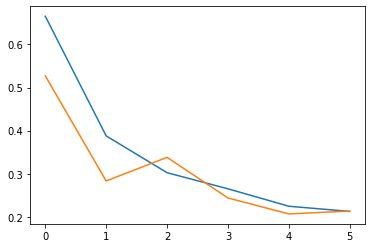

In [61]:
log=pd.read_csv('logs/my_exp/version_0/metrics.csv')
#train:blue,val:orange
log[['train_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss'].plot();
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot();

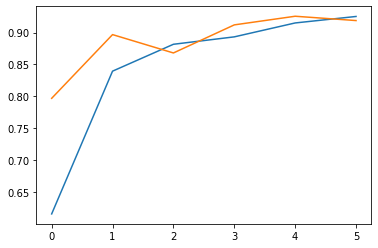

In [62]:
log[['train_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['train_acc'].plot();
log[['val_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot();

#Attentionの可視化

In [63]:
# 文字にハイライトを付ける
def highlight(word, attn):
    html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))
    return '<span style="background-color: {}">{}</span>'.format(html_color, word)


def mk_html(index, batch, preds, attention):
    # ミニバッチの入力データを取得
    sentence = batch.x[index]
    # 教師データを取得
    label =batch.t[index].item()
    # 予測ラベルを取得
    pred = preds[index].item()
    
    # 教師データから、カテゴリの名前を取得　　　　　　
    label_str = id2cat[label]
    # 予測ラベルから予測したカテゴリの名前を取得
    pred_str = id2cat[pred]

    # 正解と予測の表示
    html = "正解: {}<br>予測: {}<br><br>".format(label_str, pred_str)

    # 文章の長さ分の 0 のみの配列を取得
    seq_len = attention.size()[2]
    all_attens = torch.zeros(seq_len).to(device)
    
    # Attention Weight を取得して、作成した　０ の配列に足す
    for i in range(12):
        all_attens += attention[index, i, 0, :]
    # Attention　Weight の最大値で割、規格化
    all_attens /= all_attens.max()

    # 作成した all_attens と単語を渡す
    for word, attn in zip(sentence, all_attens):
        # 一文の終わり（`[SEP]`） が来たら break
        if tokenizer.convert_ids_to_tokens([word.tolist()])[0] == "[SEP]":
            break
        html += highlight(tokenizer.convert_ids_to_tokens([word.tolist()])[0], attn)
    return html

In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Attention Weight と予測ラベルの取得
batch = next(iter(test_loader))  

net.eval().to(device)
score, attentions = net(batch.x.to(device))
_, pred = torch.max(score, 1)

In [65]:
# Attention Weight の注目を可視化
from IPython.display import display, HTML
for i in range(5):
    html_output = mk_html(i, batch, pred, attentions[-1])
    display(HTML(html_output))
    print('---------------------------')

---------------------------


---------------------------


---------------------------


---------------------------


---------------------------


# 学習済みモデルの保存  
学習が終わると学習済みモデルが得られる。PyTorch で準備されている torch.save の関数を使用すれば保存できる。保存の際には、モデルの名前と学習済みモデルを指定する。

https://free.kikagaku.ai/tutorial/basic_of_deep_learning/learn/pytorch_classification

In [66]:
# モデルの重み
net.state_dict()

OrderedDict([('bert.embeddings.position_ids',
              tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
                        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
                        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
                        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
                        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
                        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
                        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
                        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
                       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
                       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
                       1

In [67]:
# 学習済みモデルを保存
torch.save(net.state_dict(), '/content/drive/MyDrive/kikagakuNLP/prac_data2/negaposi.pt')

# 学習済みモデルを使用した推論

In [68]:
# インスタンス化
net = BertClassifier()
#学習済みモデルの重みをロードする
net.load_state_dict(torch.load('/content/drive/MyDrive/kikagakuNLP/prac_data2/negaposi.pt'))

<All keys matched successfully>

testデータで実際に予測する

https://qiita.com/ysiny/items/b01250228e0c5cc0e647

https://note.nkmk.me/python-pandas-at-iat-loc-iloc/

https://mochablog.org/pandas-rename-columns/

In [107]:
df=pd.read_csv('/content/drive/MyDrive/kikagakuNLP/prac_data2/pred_test.csv',encoding='utf-8',names=("INPUT","LABEL"))
df

,INPUT,LABEL
0,新規店舗の寄与等により増収となりましたが、既存店の減収（同△4.5％）や記念キャンペーンに伴...,0
1,物流業界におきましては、設備投資の伸び悩み等から生産関連貨物が減少した一方、消費関連貨物は個...,0
2,航空事業は、輸出で医療機器関連品等の出荷を取扱ったものの、前期のスポット出荷が剥落した影響も...,0
3,その他のセグメントでは駐輪システムが堅調に推移し、売上高は721百万円（前年同期比0.8％増...,1
4,輸入は、電子・電気機器関連品や自動車関連部品等は底堅い荷動きとなりましたが、取扱件数は前期比...,1
5,"以上の結果、当事業年度の売上高は7,292,771千円と、前事業年度に比べ931,658千円...",0
6,利益面につきましては、営業利益１億80百万円（前期比48.1％減）、経常利益１億84百万円（...,0
7,"賃貸・割賦事業では、契約実行高はCSI Leasing, Inc.の連結子会社化などにより前...",1
8,"これらの結果、営業収益は95,973百万円（前期比18.4％減）、セグメント損失（営業損失）...",0
9,"その結果、当連結会計年度の業績は、売上収益が428,913百万円（前連結会計年度比4.2％減...",1


In [110]:
net.eval().to(device)
oof=[]#予測結果を入れるための空のリスト

for index, row in df.iterrows():
  score,attentions =net(tokenizer.encode(row['INPUT'],return_tensors='pt').to(device))
  _,preds =torch.max(score,1)#ラベルを予測
  oof.append(preds[0].tolist())
  print("score:",score,"大きい方の値:",_,"大きい方のindex:",preds)

score: tensor([[ 0.0038, -0.0619]], device='cuda:0', grad_fn=<AddmmBackward0>) 大きい方の値: tensor([0.0038], device='cuda:0', grad_fn=<MaxBackward0>) 大きい方のindex: tensor([0], device='cuda:0')
score: tensor([[-0.0882, -0.3211]], device='cuda:0', grad_fn=<AddmmBackward0>) 大きい方の値: tensor([-0.0882], device='cuda:0', grad_fn=<MaxBackward0>) 大きい方のindex: tensor([0], device='cuda:0')
score: tensor([[ 0.9800, -1.1061]], device='cuda:0', grad_fn=<AddmmBackward0>) 大きい方の値: tensor([0.9800], device='cuda:0', grad_fn=<MaxBackward0>) 大きい方のindex: tensor([0], device='cuda:0')
score: tensor([[-3.0653,  2.0170]], device='cuda:0', grad_fn=<AddmmBackward0>) 大きい方の値: tensor([2.0170], device='cuda:0', grad_fn=<MaxBackward0>) 大きい方のindex: tensor([1], device='cuda:0')
score: tensor([[-1.4979,  0.7940]], device='cuda:0', grad_fn=<AddmmBackward0>) 大きい方の値: tensor([0.7940], device='cuda:0', grad_fn=<MaxBackward0>) 大きい方のindex: tensor([1], device='cuda:0')
score: tensor([[ 1.6945, -1.7716]], device='cuda:0', grad_fn=<AddmmBa

In [111]:
df['PREDIC']=oof

In [112]:
df

,INPUT,LABEL,PREDIC
0,新規店舗の寄与等により増収となりましたが、既存店の減収（同△4.5％）や記念キャンペーンに伴...,0,0
1,物流業界におきましては、設備投資の伸び悩み等から生産関連貨物が減少した一方、消費関連貨物は個...,0,0
2,航空事業は、輸出で医療機器関連品等の出荷を取扱ったものの、前期のスポット出荷が剥落した影響も...,0,0
3,その他のセグメントでは駐輪システムが堅調に推移し、売上高は721百万円（前年同期比0.8％増...,1,1
4,輸入は、電子・電気機器関連品や自動車関連部品等は底堅い荷動きとなりましたが、取扱件数は前期比...,1,1
5,"以上の結果、当事業年度の売上高は7,292,771千円と、前事業年度に比べ931,658千円...",0,0
6,利益面につきましては、営業利益１億80百万円（前期比48.1％減）、経常利益１億84百万円（...,0,0
7,"賃貸・割賦事業では、契約実行高はCSI Leasing, Inc.の連結子会社化などにより前...",1,1
8,"これらの結果、営業収益は95,973百万円（前期比18.4％減）、セグメント損失（営業損失）...",0,0
9,"その結果、当連結会計年度の業績は、売上収益が428,913百万円（前連結会計年度比4.2％減...",1,1


列名変更  
https://note.nkmk.me/python-pandas-dataframe-rename/  
インデックスを列に  
https://www.delftstack.com/ja/howto/python-pandas/how-to-convert-index-of-a-pandas-dataframe-into-a-column/　　


In [113]:
#indexを列に追加
df['id'] = df.index
#列名を変更
df_for_submission = df.rename(columns={'PREDIC': 'pred'})

In [120]:
df_for_submission=df_for_submission[["id","pred"]]
df_for_submission
df_for_submission.to_csv('for_submission.csv',index=None,header=None)

In [117]:
df_for_submission

,id,pred
0,0,0
1,1,0
2,2,0
3,3,1
4,4,1
5,5,0
6,6,0
7,7,1
8,8,0
9,9,1
